In [1]:
!pip install tqdm
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from typing import Tuple, List
# new import statements
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Retailrocket recommender system dataset

Source: https://www.kaggle.com/retailrocket/ecommerce-dataset

Load the dataset files.

In [3]:
events = pd.read_csv(os.path.join('data', 'events.csv'))
item_properties = pd.read_csv(os.path.join('data', 'item_properties_part1.csv'))
category_tree = pd.read_csv(os.path.join('data', 'category_tree.csv'))

In [4]:
events

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [5]:
item_properties

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [6]:
category_tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [7]:
events['event_datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
events['event_date'] = events['event_datetime'].dt.date
events

,timestamp,visitorid,event,itemid,transactionid,event_datetime,event_date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02
...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,2015-08-01
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,2015-08-01
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2015-08-01
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,2015-08-01


## Statistical model for timeseries analysis

### 1. Exponential Moving Average (EMA)
EMA is a quantitative technique used as a forecasting model for time series analysis. It is a statistical method used to smooth time-series data by giving more weight to recent observations and less weight to older ones. It's useful in scenarios where recent data points are considered more relevant and informative. Typical use case scenarios include financial time-series analysis or e-commerce product popularity prediction.

### pandas ewm

- Documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html.

#### Q5: Use an Exponential Moving Average (EMA) model to calculate the average itemid view counts per category in the events dataset. Calculate the EMA for each category over a specified span.

#### 2. Linear Regression

If the dataset exhibits a linear trend (either increasing or decreasing), linear regression can be a good starting point for short-term forecasting. 

A simple linear regression model fits a line to the data, assuming a linear relationship between the independent variable (time) and the dependent variable (views in our example).

#### Merge `events` with `category_items`.

In [8]:
events

,timestamp,visitorid,event,itemid,transactionid,event_datetime,event_date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02
...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,2015-08-01
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,2015-08-01
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2015-08-01
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,2015-08-01


In [9]:
category_items = item_properties[item_properties['property'] == 'categoryid'][['itemid', 'value']]
# 'value' column contains the category IDs, so let's rename value to categoryid
category_items.columns = ['itemid', 'categoryid']  
category_items['categoryid'] = category_items['categoryid'].astype(int)
category_items

,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47
...,...,...
10999880,441523,1167
10999917,250848,769
10999932,116380,1509
10999960,84186,209


In [10]:
category_items

,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47
...,...,...
10999880,441523,1167
10999917,250848,769
10999932,116380,1509
10999960,84186,209


In [11]:
events_with_categories = pd.merge(events, category_items, on="itemid", how="left")

#### Group `events` by `category` and `timestamp` to get view counts.

In [12]:
grouped_data = (
    events_with_categories[events_with_categories['event'] == 'view']
    .groupby(['timestamp', 'categoryid'])
    .size()
    .reset_index(name='view_count')  # Add a new column for aggregated counts
)

In [13]:
grouped_data

,timestamp,categoryid,view_count
0,1430622028399,421.0,5
1,1430622028399,1674.0,13
2,1430622033686,1339.0,1
3,1430622036210,368.0,1
4,1430622040988,683.0,1
...,...,...,...
1459107,1442545134195,1196.0,1
1459108,1442545152365,1293.0,1
1459109,1442545153842,956.0,1
1459110,1442545174109,491.0,1


#### Train test split

In [14]:
train, test = train_test_split(grouped_data, test_size=0.2, random_state=42)

In [15]:
categories = train['categoryid'].unique()
models = {}

# Train a Linear Regression model for each category
for category in tqdm(categories, total=len(categories)):
    category_train_data = train[train['categoryid'] == category]
    
    # Define target and features
    y = category_train_data['view_count']
    X = category_train_data[['timestamp']]  
    # In P6, you will be dropping id, date, and sales to create your feature vector 
    
    X = np.array(X).reshape(-1, 1).astype(np.float32)
    y = np.array(y).astype(np.float32)
    
    # Train the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the model
    models[category] = model

100%|█████████████████████████████████████████████████████████████| 1112/1112 [00:04<00:00, 264.31it/s]


#### Predict on test set

In [16]:
test['predicted_view_count'] = np.nan  # Placeholder for predictions

for category in tqdm(categories, total=len(categories)):
    # Filter test data for the current category
    category_test_data = test[test['categoryid'] == category]
    
    # Skip if there's no data for this category
    if category_test_data.empty:
        print(f"No test data for category {category}. Skipping predictions.")
        continue
    
    if category in models:
        X_test = category_test_data[['timestamp']].to_numpy().reshape(-1, 1).astype(np.float32)
        
        # Skip prediction if there are no rows in X_test
        if X_test.shape[0] == 0:
            print(f"No valid test samples for category {category}. Skipping.")
            continue
        
        test.loc[test['categoryid'] == category, 'predicted_view_count'] = models[category].predict(X_test)

# Output the predictions
print(test[['timestamp', 'categoryid', 'view_count', 'predicted_view_count']].head())

 49%|██████████████████████████████▏                               | 541/1112 [00:01<00:01, 394.19it/s]

No test data for category 1100.0. Skipping predictions.


 60%|█████████████████████████████████████▏                        | 667/1112 [00:01<00:01, 407.83it/s]

No test data for category 780.0. Skipping predictions.


 75%|██████████████████████████████████████████████▌               | 834/1112 [00:02<00:00, 409.07it/s]

No test data for category 1590.0. Skipping predictions.


 90%|██████████████████████████████████████████████████████▉      | 1001/1112 [00:02<00:00, 408.14it/s]

No test data for category 713.0. Skipping predictions.
No test data for category 1499.0. Skipping predictions.
No test data for category 501.0. Skipping predictions.
No test data for category 922.0. Skipping predictions.
No test data for category 1068.0. Skipping predictions.
No test data for category 1134.0. Skipping predictions.
No test data for category 1310.0. Skipping predictions.
No test data for category 60.0. Skipping predictions.
No test data for category 902.0. Skipping predictions.
No test data for category 667.0. Skipping predictions.


100%|█████████████████████████████████████████████████████████████| 1112/1112 [00:02<00:00, 405.14it/s]

No test data for category 45.0. Skipping predictions.
No test data for category 357.0. Skipping predictions.
No test data for category 1406.0. Skipping predictions.
No test data for category 908.0. Skipping predictions.
No test data for category 601.0. Skipping predictions.
No test data for category 981.0. Skipping predictions.
No test data for category 1449.0. Skipping predictions.
No test data for category 1354.0. Skipping predictions.
No test data for category 749.0. Skipping predictions.
No test data for category 433.0. Skipping predictions.
No test data for category 1427.0. Skipping predictions.
No test data for category 534.0. Skipping predictions.
No test data for category 32.0. Skipping predictions.
No test data for category 1489.0. Skipping predictions.
No test data for category 412.0. Skipping predictions.
No test data for category 1411.0. Skipping predictions.
No test data for category 264.0. Skipping predictions.
No test data for category 1442.0. Skipping predictions.
No te

### 3. ARIMA (Autoregressive Integrated Moving Average) model

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

Autocorrelation and partial autocorrelation are statistical measures that help analyze the relationship between a time series and its lagged values. They help identify patterns, trends, and dependencies in the data, which are crucial for model selection and evaluation.

### Autocorrelation

- Autocorrelation measures the linear relationship between a time series and its lagged values. In simpler terms, it assesses how much the current value of a series depends on its past values. 
- Used for identifying the order of a moving average (MA) process.
- Represents the overall correlation structure of the time series.
- Autocorrelation measures the linear relationship between an observation and its previous observations at different lags.
- Use case:
    - To identify repeated patterns (seasonality).
    - To assess whether a time series is random or has some dependency.
    - To decide if a time series has autoregressive (AR) components.

### Partial Autocorrelation
- Partial autocorrelation removes the influence of intermediate lags, providing a clearer picture of the direct relationship between a variable and its past values. Unlike autocorrelation, partial autocorrelation focuses on the direct correlation at each lag.
- Used for identifying the order of an autoregressive (AR) process.
- Highlights the direct relationships between observations at specific lags.
- Partial Autocorrelation measures the direct linear relationship between an observation and its previous observations at a specific lag, excluding the contributions from intermediate lags.
- Use case:
    - To determine the order of an autoregressive (AR) process.
    - To identify the number of lags that have a significant and direct impact on the current value.

In [17]:
grouped_data = (
    events_with_categories[events_with_categories['event'] == 'view']
    .groupby(['event_datetime', 'categoryid'])
    .size()
    .reset_index(name='view_count') 
)
grouped_data

,event_datetime,categoryid,view_count
0,2015-05-03 03:00:28.399,421.0,5
1,2015-05-03 03:00:28.399,1674.0,13
2,2015-05-03 03:00:33.686,1339.0,1
3,2015-05-03 03:00:36.210,368.0,1
4,2015-05-03 03:00:40.988,683.0,1
...,...,...,...
1459107,2015-09-18 02:58:54.195,1196.0,1
1459108,2015-09-18 02:59:12.365,1293.0,1
1459109,2015-09-18 02:59:13.842,956.0,1
1459110,2015-09-18 02:59:34.109,491.0,1


In [18]:
category_totals = (
    grouped_data.groupby('categoryid')['view_count']
    .sum()
    .reset_index()
    .sort_values('view_count', ascending=False)
)

In [19]:
top_categories = category_totals.head(20)['categoryid'].values

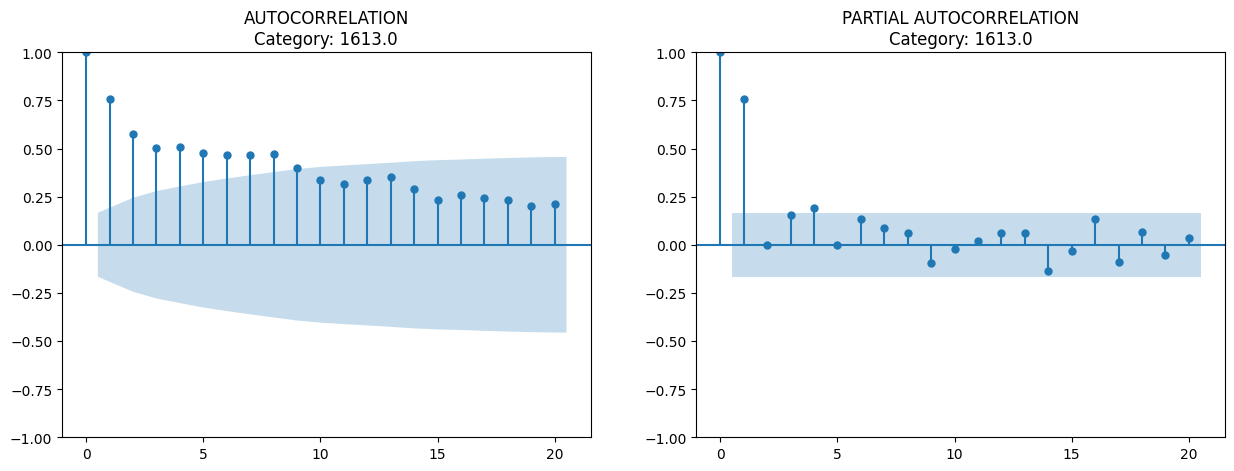

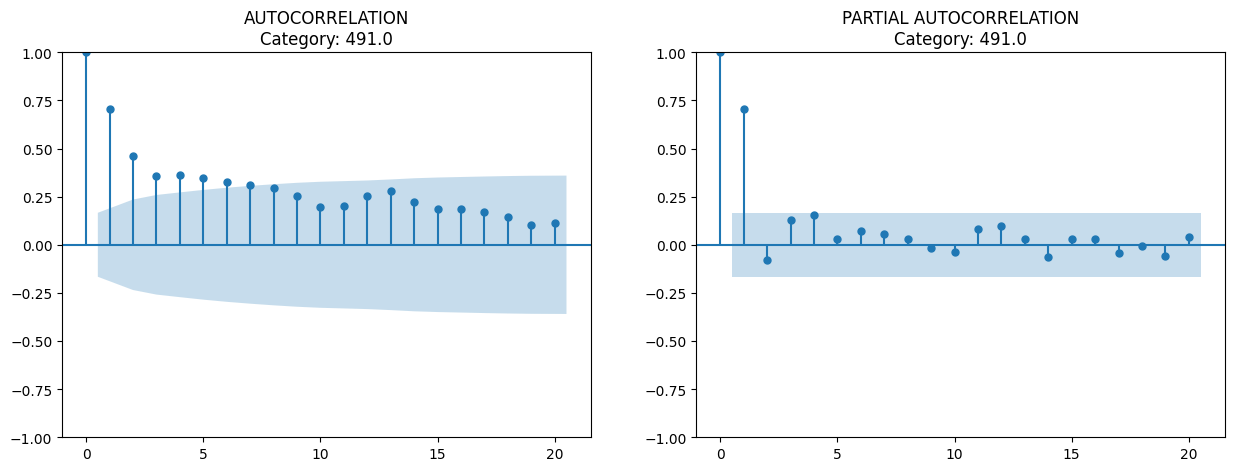

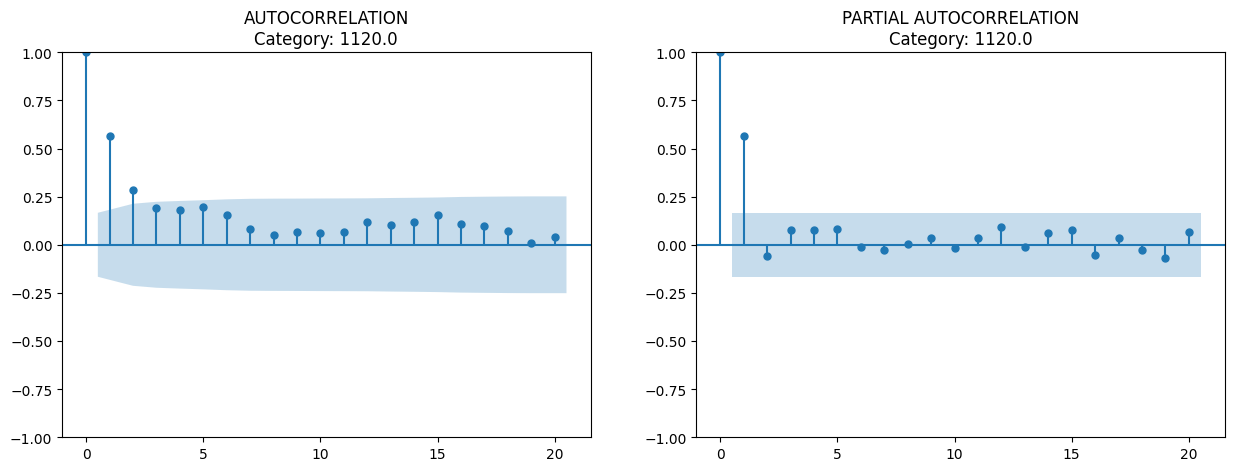

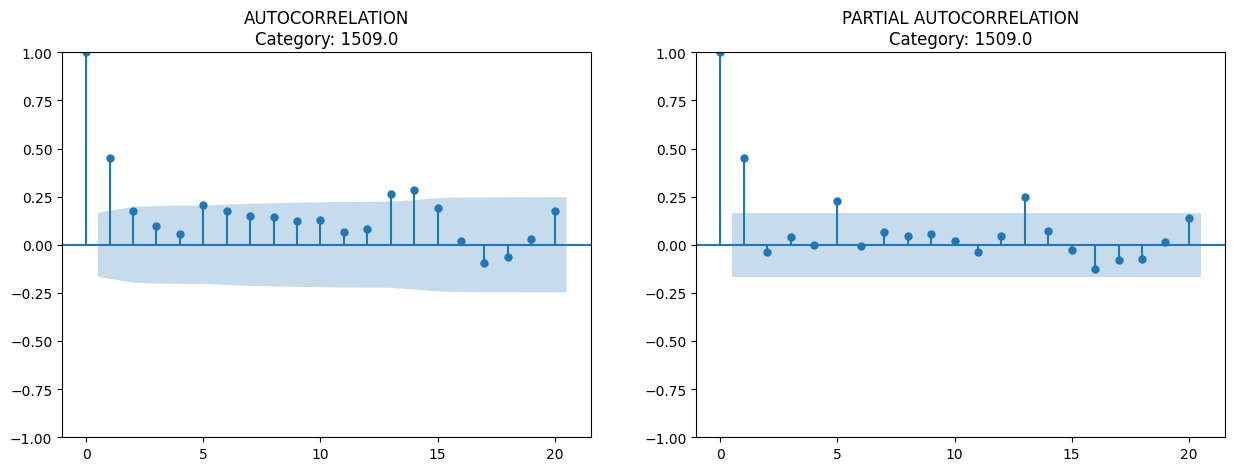

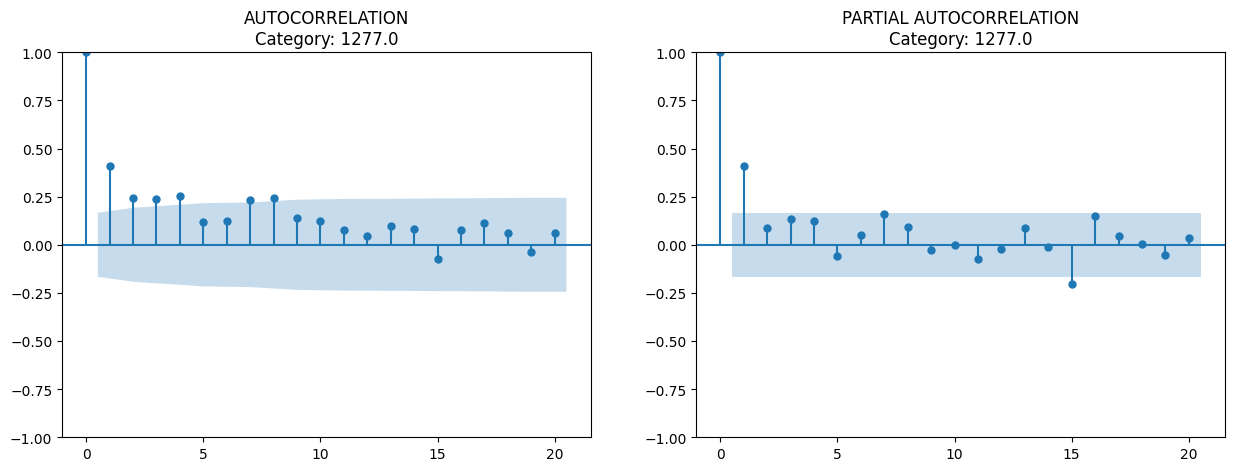

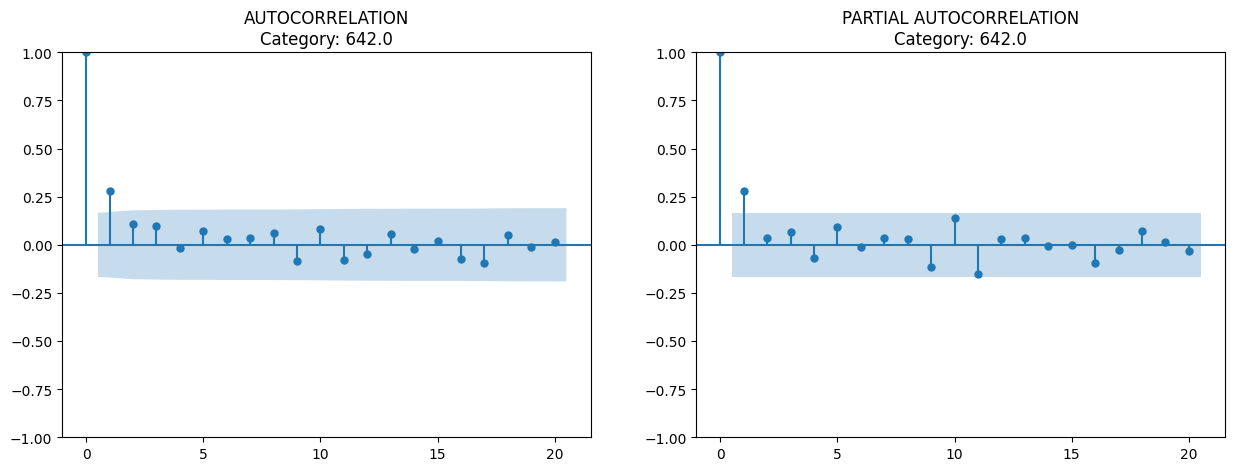

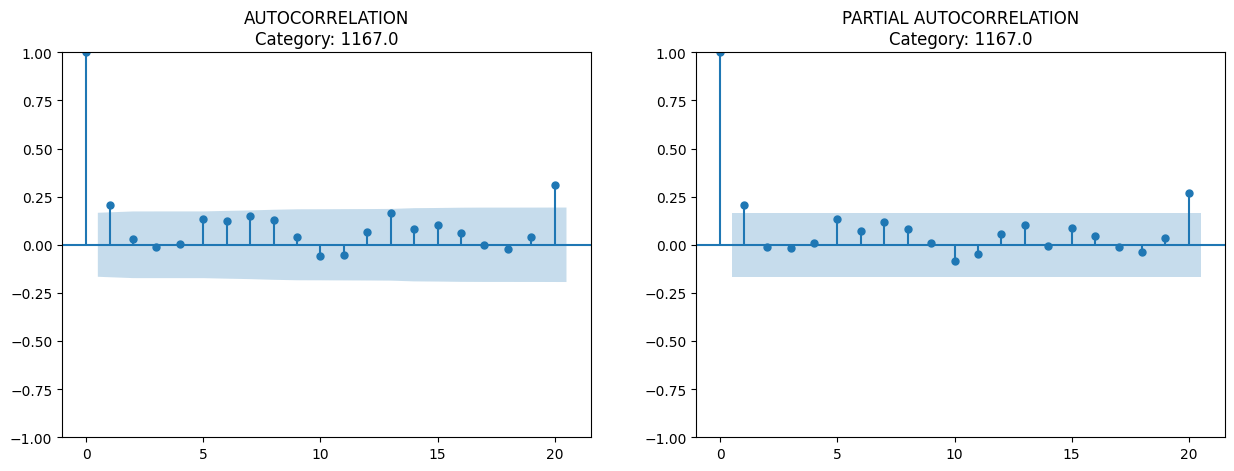

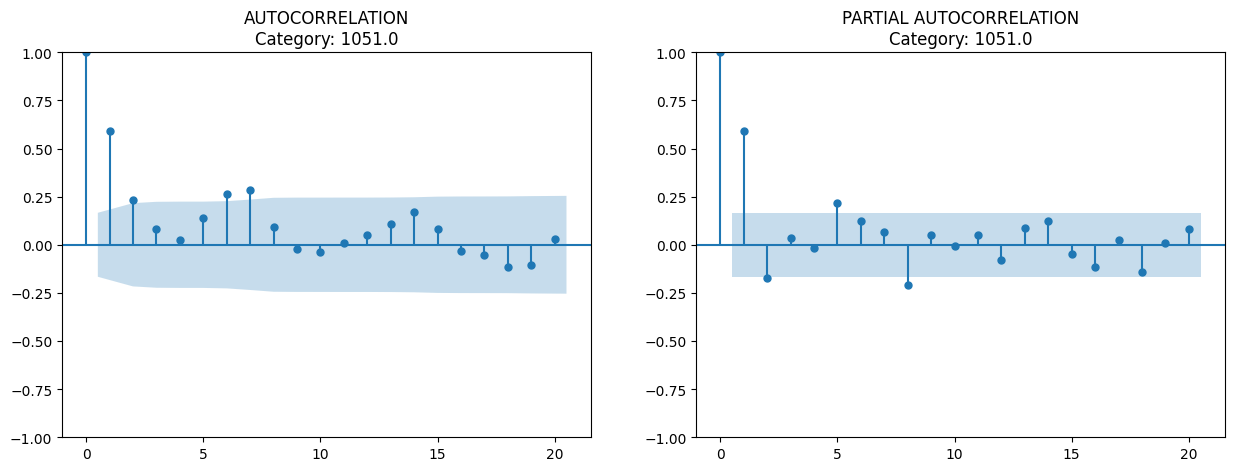

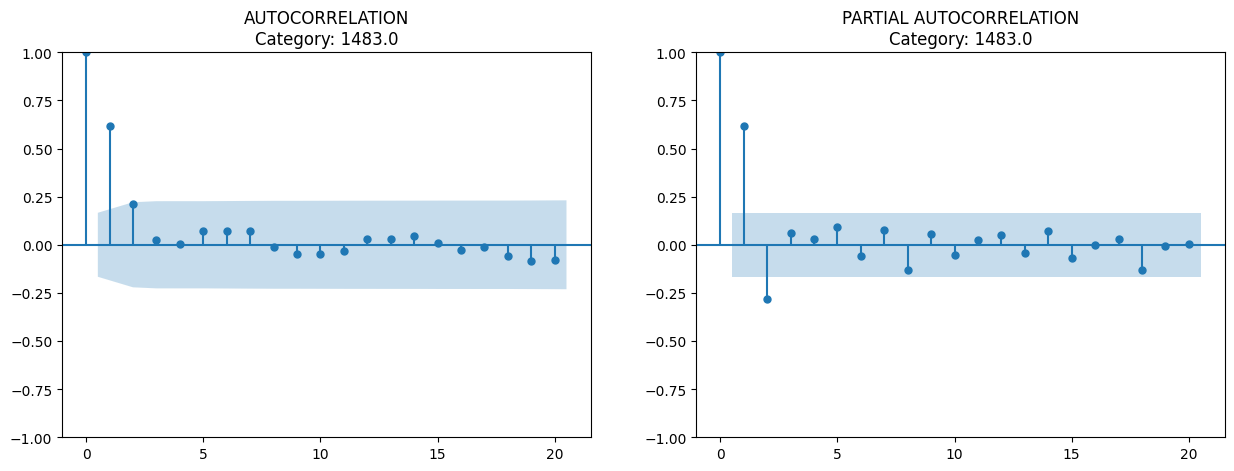

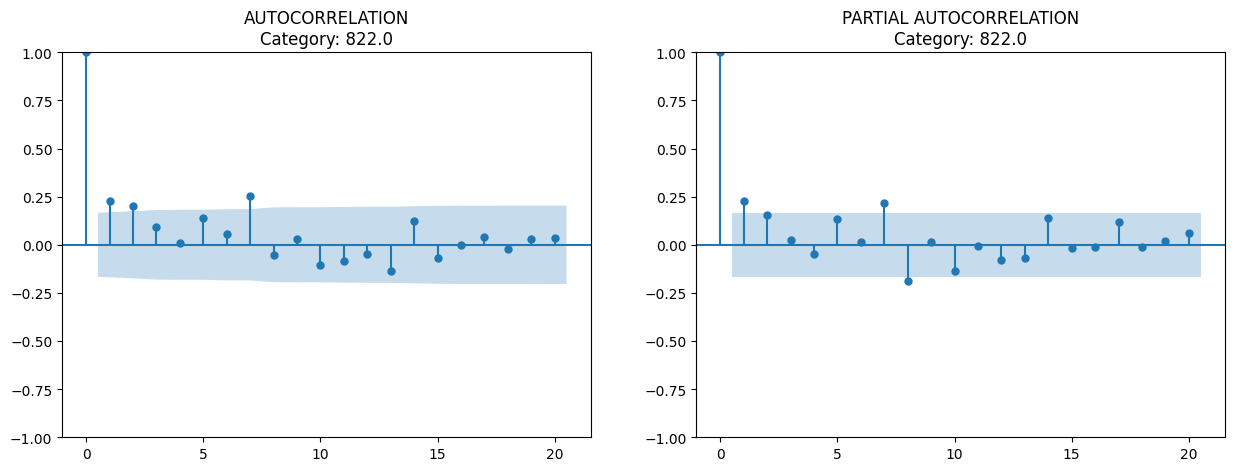

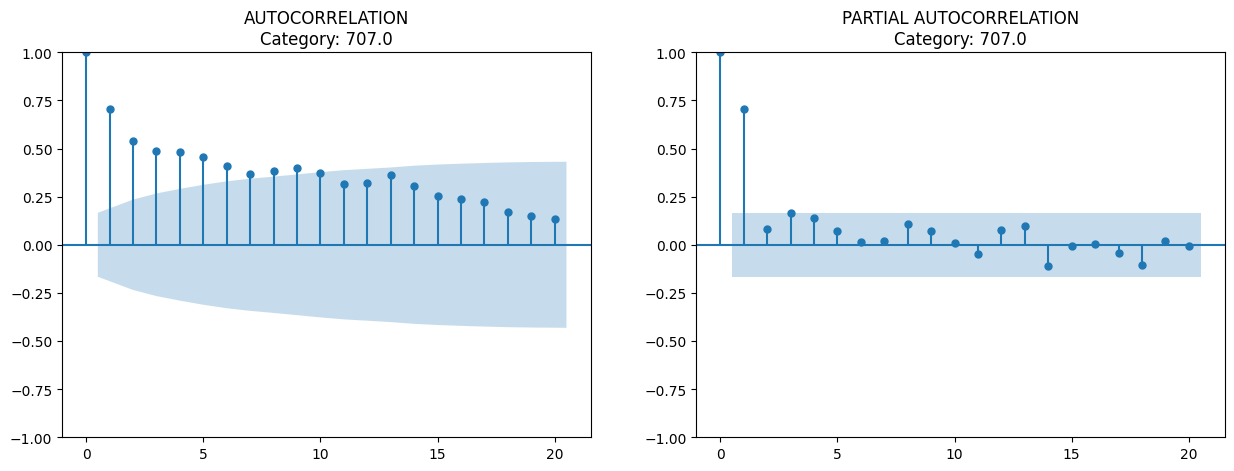

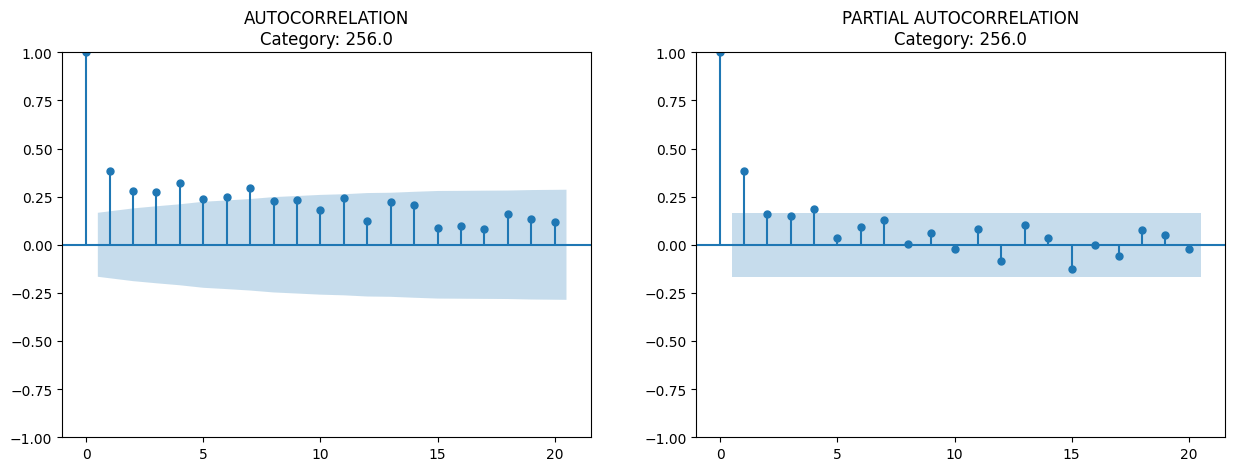

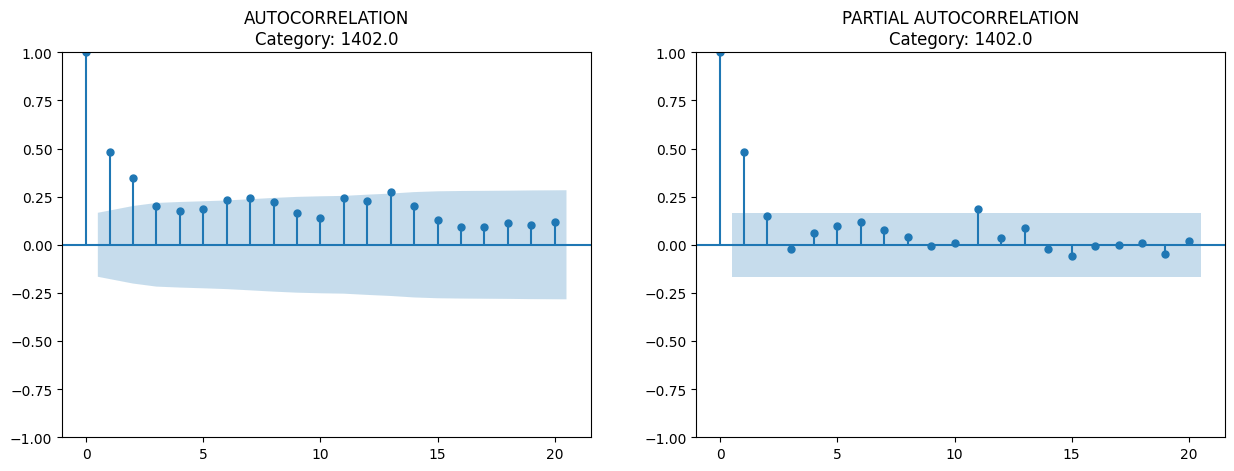

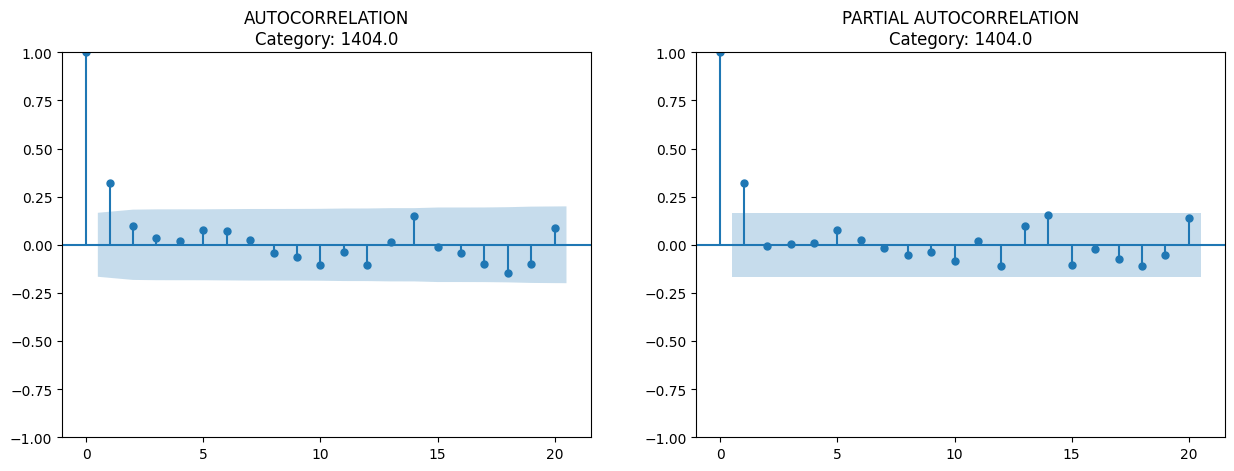

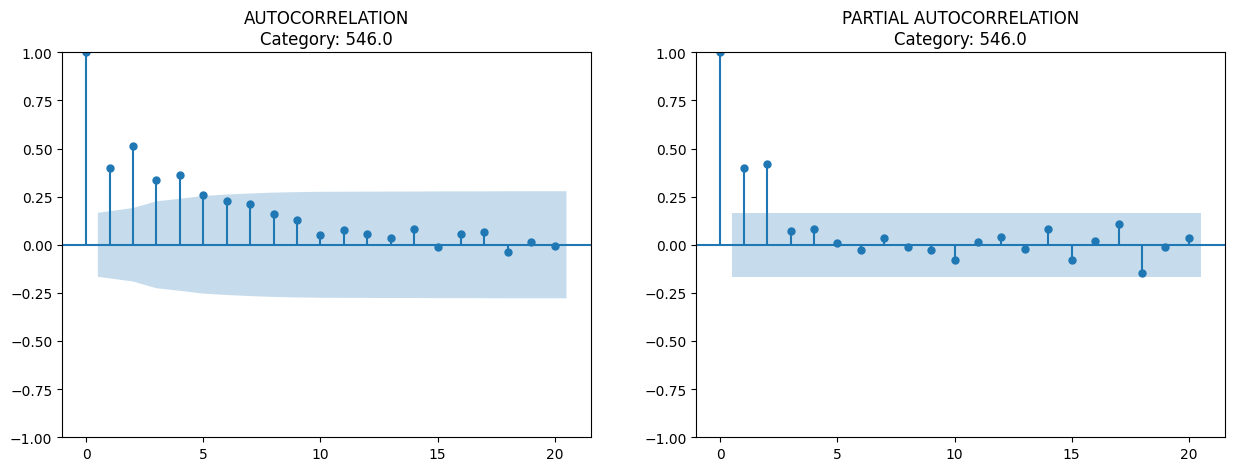

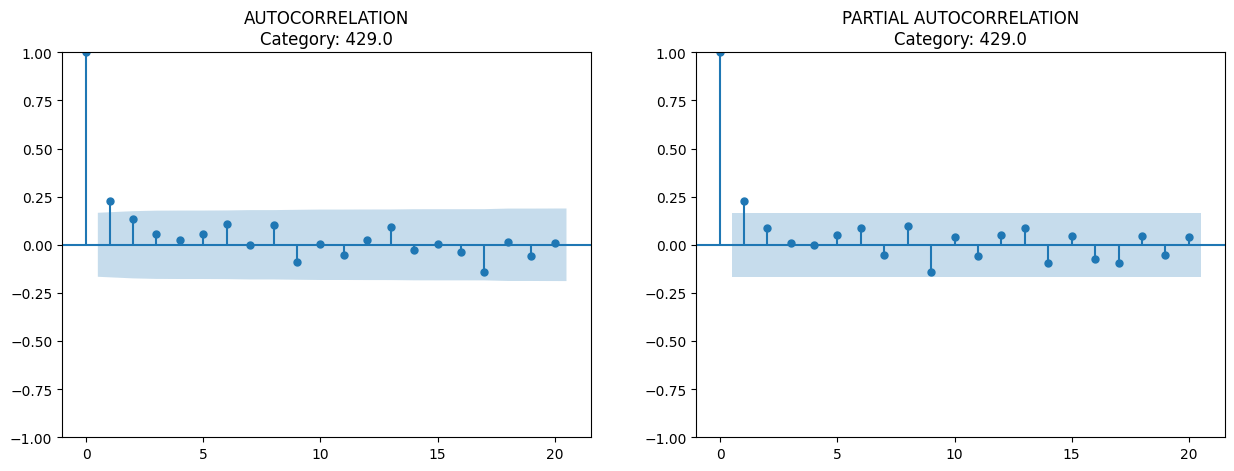

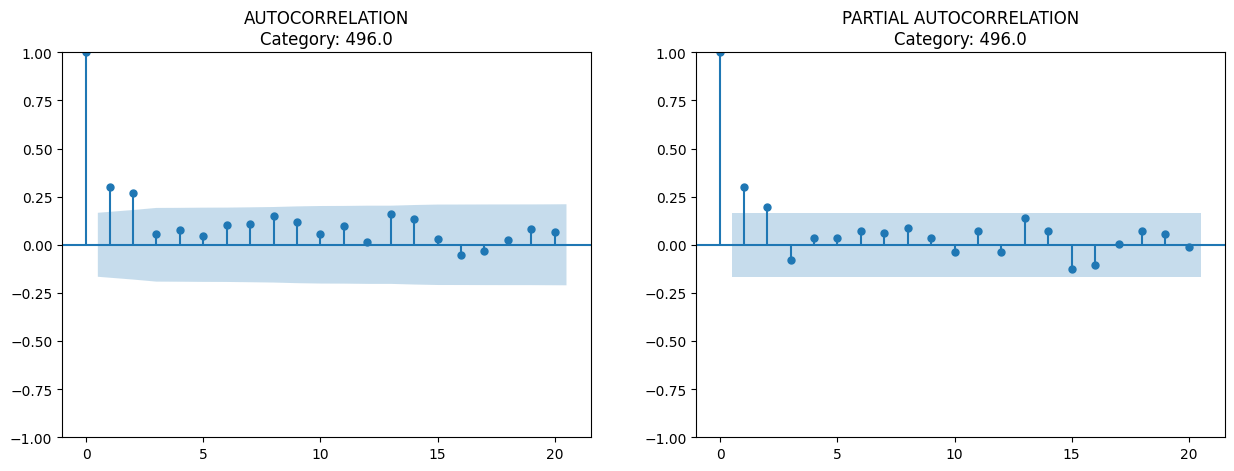

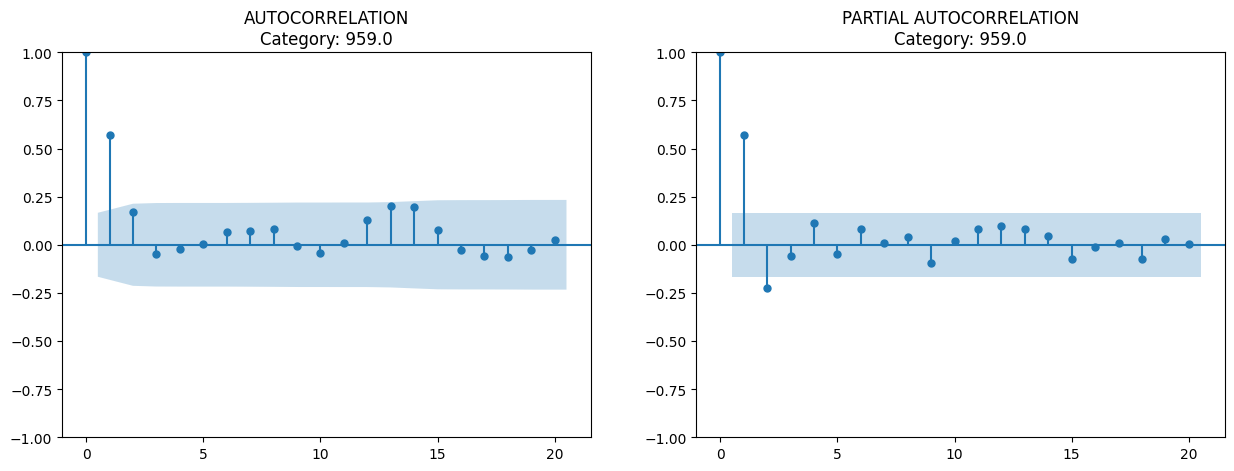

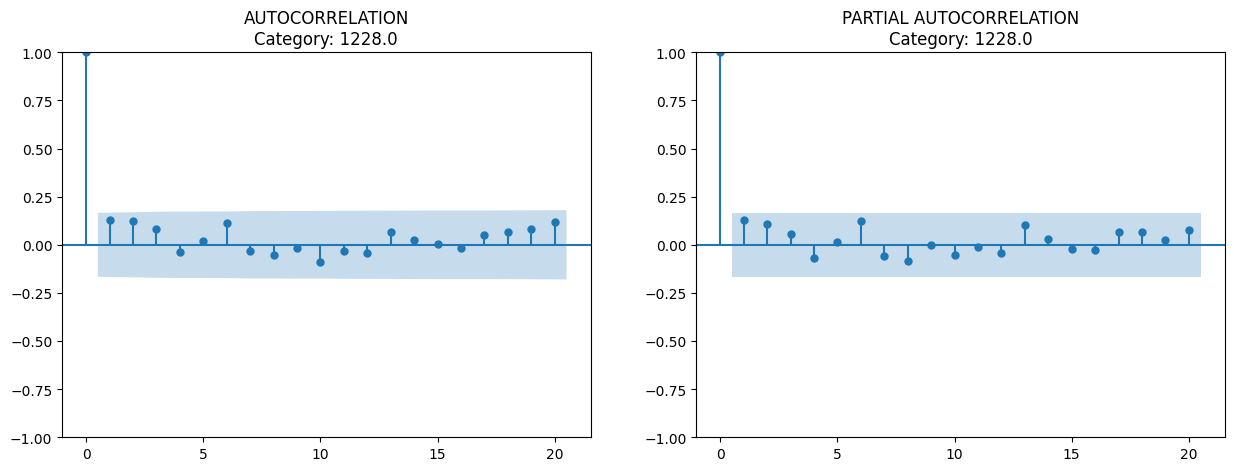

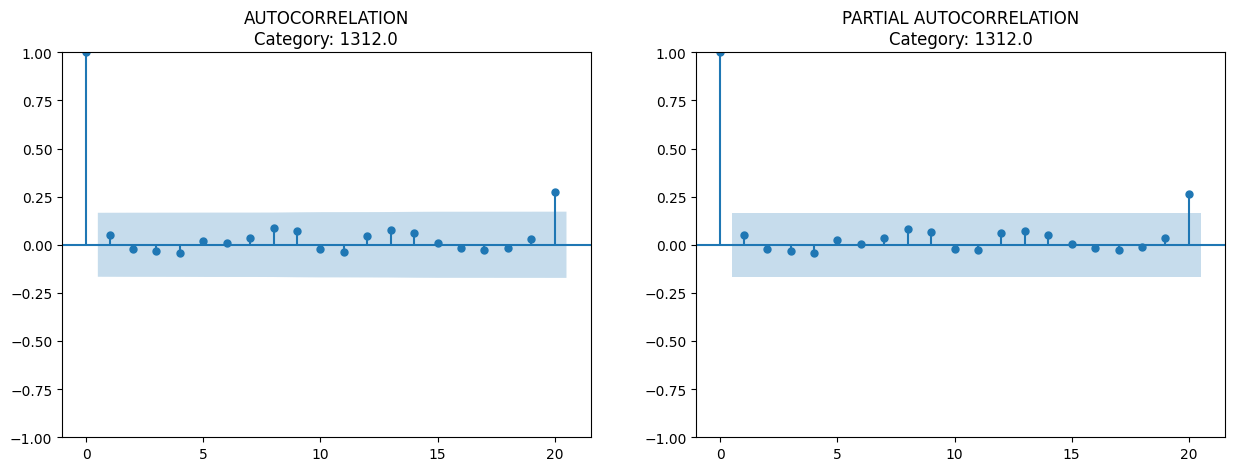

In [20]:
for num, category in enumerate(top_categories):
    try:
        category_data = grouped_data[grouped_data['categoryid'] == category]
        
        # Resample to daily view counts
        category_daily = (
            category_data.set_index('event_datetime')
            .resample('D')
            .sum()
            .fillna(0)  # Fill missing days with 0 view counts
        )
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot ACF and PACF
        plot_acf(category_daily['view_count'], lags=20, ax=ax[0], title=f"AUTOCORRELATION\nCategory: {category}")
        plot_pacf(category_daily['view_count'], lags=20, ax=ax[1], title=f"PARTIAL AUTOCORRELATION\nCategory: {category}")
        
        plt.show()
    except Exception as e:
        print(f"Error processing category {category}: {e}")
        pass

plt.close('all')

In [21]:
grouped_data = (
    events_with_categories[events_with_categories['event'] == 'view']
    .groupby(['event_date', 'categoryid'])
    .size()
    .reset_index(name='view_count') 
)
grouped_data

,event_date,categoryid,view_count
0,2015-05-03,0.0,3
1,2015-05-03,1.0,17
2,2015-05-03,3.0,5
3,2015-05-03,5.0,31
4,2015-05-03,14.0,63
...,...,...,...
95935,2015-09-18,1650.0,3
95936,2015-09-18,1659.0,6
95937,2015-09-18,1663.0,3
95938,2015-09-18,1680.0,1


### ACF and PACF for the whole view count timeseries

In [24]:
per_day_data = grouped_data.groupby('event_date')['view_count'].sum().reset_index()
per_day_data

,event_date,view_count
0,2015-05-03,16405
1,2015-05-04,22200
2,2015-05-05,25861
3,2015-05-06,26558
4,2015-05-07,27054
...,...,...
134,2015-09-14,20405
135,2015-09-15,20149
136,2015-09-16,11647
137,2015-09-17,11968


In [25]:
autocorr_values = per_day_data['view_count'].autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.6897774661516713


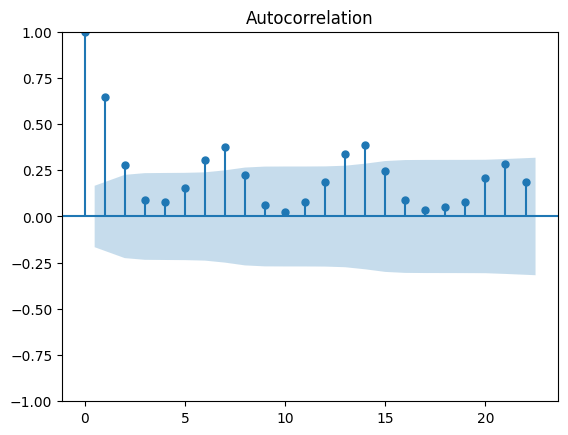

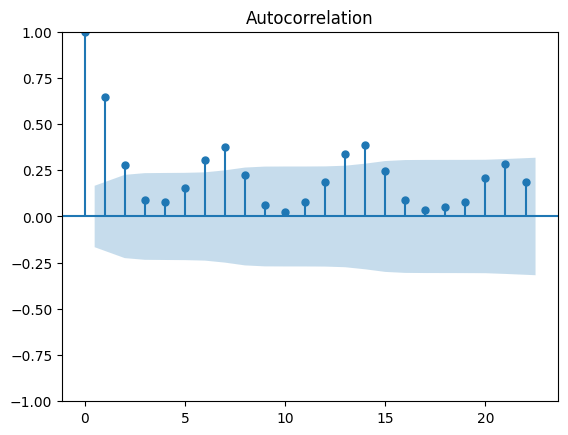

In [26]:
plot_acf(per_day_data['view_count'])

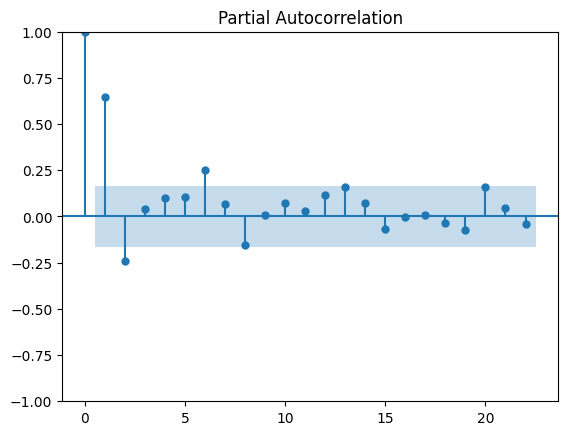

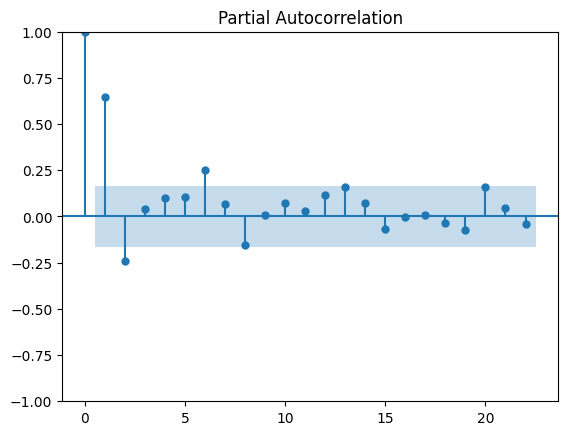

In [27]:
plot_pacf(per_day_data['view_count'])